# Titanic - Predicting Passengers chances to survive

# 0. What is the problem we want to tackle ?

In this competition, our goal is to create a model that predicts which passengers survived the Titanic shipwreck.

Before diving into the data, let's get a bit of context about the history behind the sinking of the Titanic. Understanding highlights of the chain of events will allow us to get a sense a the relevant questions we should tackle in the EDA phase and better consider the relative importance of the features we have at hand in our dataset and how to eventually combine them.

Based on the [Wikipedia page](https://fr.wikipedia.org/wiki/Naufrage_du_Titanic#:~:text=Le%20navire%20heurte%20un%20iceberg,plus%20meurtri%C3%A8re%20pour%20l'%C3%A9poque.) about the Sinking of the Titanic, we have 3 key information related to features of our dataset :

- During the evacuation of the boat, **child and females** had priority access to the lifeboats ;
- As the collision took place at the front of the boat, the **1st classes** were among the first passengers to be alerted and equipped, as their cabins were located nearby. They also had an advantage in obtaining a place in these first boats, given the proximity of their cabin to the boat deck ;
- Passengers who embarked in **Cherbourg were mainly from the first class**, while the vast majority of Irish people boarding in **Queenstone were 3rd class passengers** immigrating to the US.

Based on these information, we can already assume that the following data points will be important to predict passengers' likeliness to survive : **Age, Sex, PClass**.

# 1. Getting the data

## Import packages

First we will import all the relevant dependencies we need.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Start Python Imports
import math, time, random, datetime

# Statistical analysis
from scipy import stats

# Visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# Machine learning
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## Loading in the data

I have downloaded the data from the [Titanic competition space on Kaggle](https://www.kaggle.com/c/titanic/data).

To make our predictions, we have 3 different datasets : 
- train.csv : this the dataset we will use to build our model ; 
- test.csv : we will use this dataset to see how well your model performs on unseen data ;
- gender_submission.csv : this file is here to give us an example of how the submission file should look like.

In [2]:
# Transform csv files in dataframes
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
submission_example_data = pd.read_csv('data/gender_submission.csv')

In [3]:
# View the training data 
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# View the test data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# View the example submission data
submission_example_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [6]:
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Dataframe datatypes

Generally, when we observe features with an "object" data type they can be considered as categorical. The ones which are floats or ints are numerical features.

It can happen that some numerical fields may actually be categorical.

Ideally, we should process the data in a way that all the features will be encoded into a numerical value.

In [7]:
training_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Does the dataset contains missing values ?

From the table above, we can observe that some columns have less values than others. 

Let's understand where are the holes in our data and how it might impact the usability of features.

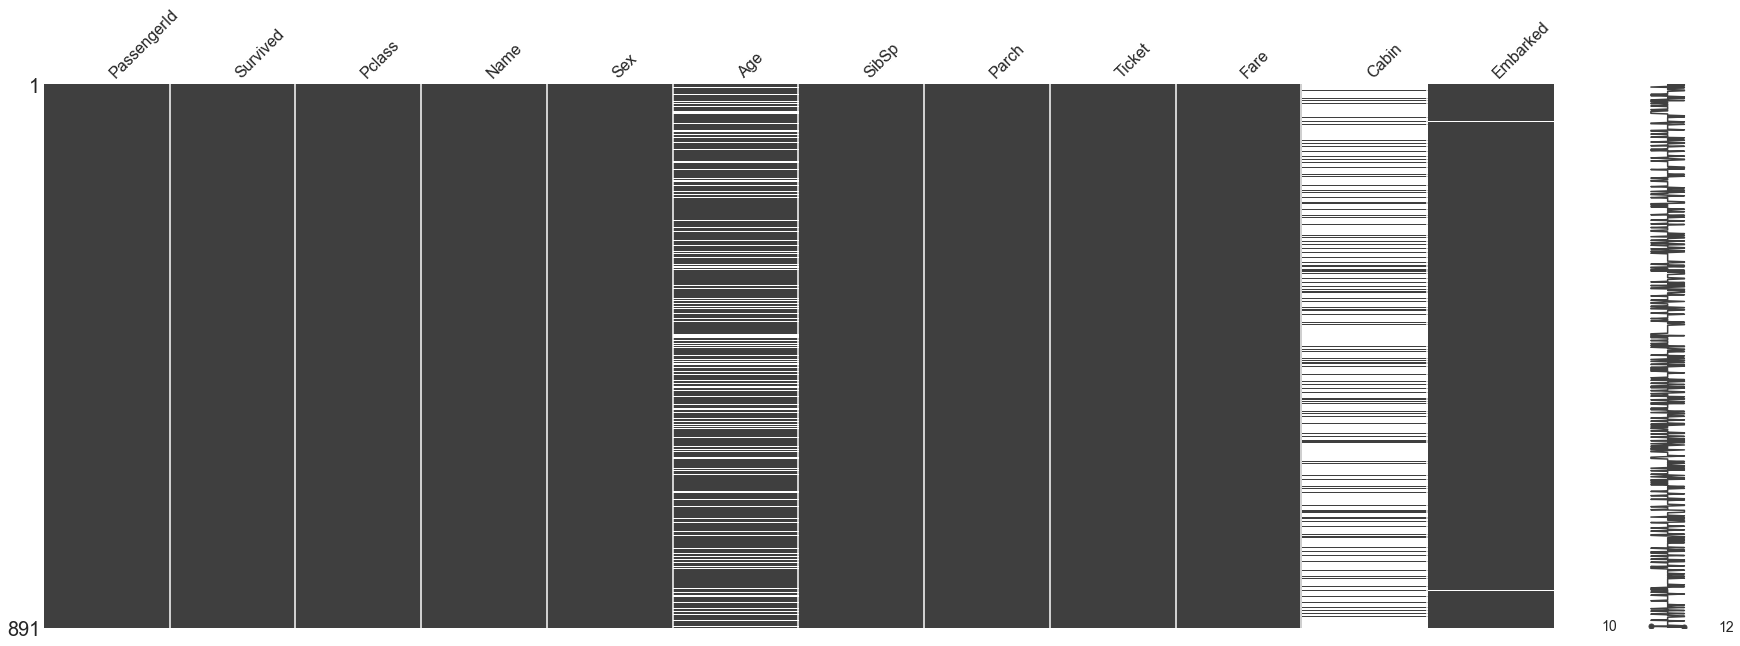

In [8]:
# Plot graphic of missing values
missingno.matrix(training_data, figsize = (30,10))

In [9]:
# function that shows the number of missing values per field
def count_missing_values(df): 
    """
    Function to count the number of missing values in each columns of the dataframe
        Parameters:
            table : dataframe that we want to scan to identify missing values
        Return:
            missing_vals (dict) : dictionnary listing the number of missing values per column
    
    """
    print('Number of missing or NaN value for each column:')
    keys = []
    values = []
    
    for element in df.columns:
        keys.append(element)
        values.append(str(df[element].isnull().sum()) + ' (' + str(round(df[element].isnull().sum()/len(df)*100, 2)) + '%)')
    
    missing_vals = {keys[i]: values[i] for i in range(len(keys))}
    
    return missing_vals

In [10]:
missing_vals = pd.DataFrame.from_dict(count_missing_values(training_data), orient='index').rename(columns={0: "Count of missing values (%)"})
missing_vals

Number of missing or NaN value for each column:


,Count of missing values (%)
PassengerId,0 (0.0%)
Survived,0 (0.0%)
Pclass,0 (0.0%)
Name,0 (0.0%)
Sex,0 (0.0%)
Age,177 (19.87%)
SibSp,0 (0.0%)
Parch,0 (0.0%)
Ticket,0 (0.0%)
Fare,0 (0.0%)


We can clearly observe that 3 columns are missing data : 
- **Age:** about 20% of values are missing, we will need to do some manipulations before moving to the modeling step ;
- **Cabin:** 77% of data is missing. It is going to be complicated to take advantage of this field considering the number of missing values ; 
- **Embarked:** there are only 2 missing values which is negligeable. We will have to decide what we do with the rows that are impacted.

# 2. Exploratory Data Analysis 

## Utils functions

We will take advantage of the following visualisation functions to help us answer exploratory questions about each feature in the Exploratory Data Analysis section. 

In [11]:
def plot_quartiles(dataset, feature, target, chart_title, categories, y_axis_label):
    """
    Function to cut a continuous variable into quartiles and visualise the target feature value per group
        Parameters
            dataset: target dataframe
            feature: name of the feature we want to cut into bins (quartiles)
            target: name of the target feature
            chart_title: title of the chart
            categories: name of the 4 categories
            y_axis_label: title of the y axis
        Return
            bar_plot: bar graph of the categories target feature value
    """
    fig, axarr = plt.subplots(figsize=(5,5))
    cat_ranges = pd.qcut(dataset[feature], len(categories), labels = categories)
    axarr.set_title(chart_title)
    sns.barplot(x=cat_ranges, y=dataset[target], ci=None, ax=axarr).set_ylabel(y_axis_label)

In [12]:
def bar_chart_compare(dataset, chart_title, feature1, feature2, target, y_axis_label):
    """
    Function to plot a bar graph of the target feature value segmented by categories
        Parameters
            dataset: target dataframe
            chart_title: title of the chart
            feature1: feature that we want to compare 
            feature2: name of the feature we will use to segment feature1 
            target: name of the target feature
            y_axis_label: title of the y axis
        Return
            bar_plot: bar graph of the target feature value segmented by categories
    """
    plt.figure(figsize = [5, 5])
    plt.title(chart_title)
    g = sns.barplot(x=feature1, y=target, hue=feature2, ci=None, data=dataset).set_ylabel(y_axis_label)

In [13]:
def countplot_compare(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize= (5,5))
    p = sns.countplot(x=feature1, hue=feature2, data=dataset, ax=ax).set_title(title)

In [14]:
def bar_chart_stacked(dataset, feature, stacked=True):
    """
    Function to plot a stacked bar chart of passengers who survived vs died segmented by a specific feature
        Parameters
            dataset: target dataframe
            feature: ame of the feature we will use to segment passengers 
            stacked: whether the bar graph is stacked or not
        Return
            bar_plot: stacked bar graph of the target feature value segmented by a specific feature
    """
    survived = dataset[dataset['Survived'] == 1][feature].value_counts()
    dead = dataset[dataset['Survived'] == 0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived, dead])
    df_survived_dead.index = ['Passengers Survived', 'Passenger Died']
    ax = df_survived_dead.plot(kind='bar', stacked=stacked, figsize=(5,5))

In [15]:
def plot_swarm(dataset, target, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.grid(True)
    plt.xticks(list(range(0, 100, 2)))
    sns.swarmplot(y=feature1, x=feature2, hue=target, data= dataset).set_title(title)

In [16]:
def plot_kernel_density_estimate_survivors(dataset, feature1, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title = title
    sns.kdeplot(dataset[feature1].loc[dataset["Survived"] == 1], shade = True, ax=ax, label= "Survived")
    sns.kdeplot(dataset[feature1].loc[dataset["Survived"] == 0], shade = True, ax=ax, label= "Died")

In [17]:
def countplot(dataset, feature, title, fsize):
    fig, ax = plt.subplots(figsize= fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)

## Question #1 : How many passengers survived ?

Feature: Survived

Description: Whether the passenger survived or not.

Key: 0 = did not survive, 1 = survived

Survive is our target feature. It is the one that we want to predict with our Machine Learning model based off all the others.

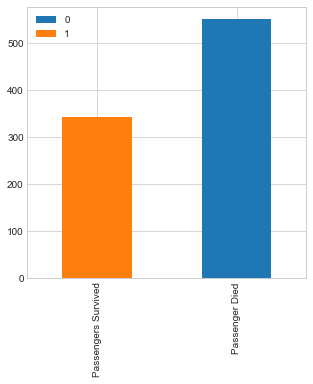

In [18]:
# plot the number of passengers who survived vs died
bar_chart_stacked(training_data, "Survived")

In [19]:
# print the % of passengers who survived
print("{} % of passengers survived the distaster.".format(round(training_data.Survived.value_counts()[1]/training_data.Survived.value_counts().sum(), 2)*100))

38.0 % of passengers survived the distaster.


## Question #2 : Does the likelihood of survival depends on gender ?

Feature: Sex

Description: Sex of the passengers.

Keys : male or female.

In [20]:
# count the number of passengers per sex
training_data.Sex.value_counts().to_frame()

,Sex
male,577
female,314


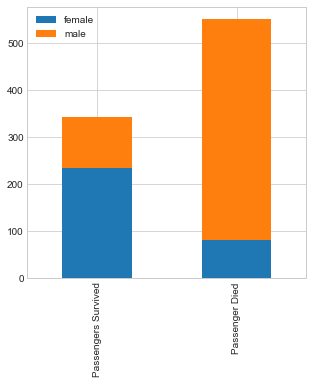

In [21]:
# plot survival rate bar chart per sex
bar_chart_stacked(training_data, "Sex")

In [22]:
# compute the percentage of survivors per sex
training_data.groupby("Sex").Survived.mean().to_frame()

,Survived
Sex,
female,0.742038
male,0.188908


Overall, we can observe that although the majority of passengers were men, the majority of survivors were women.

This observation confirms that women and children first is indeed a rule that has been respected to save passengers during the sink of the Titanic.

## Question #3 : Does the class to which a passenger belongs plays a role in his chances of survival ?

Feature: Pclass

Description: The class in which the passenger travels.

Key: 1 = 1st class ; 2 = 2nd class ; 3 = 3rd class.

In [23]:
# count the passengers who died/survived per Pclass
pd.pivot_table(training_data, index = 'Survived', columns = 'Pclass', values = 'Ticket', aggfunc='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [24]:
# compute the percentage of survivors per Pclass
training_data.groupby("Pclass").Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


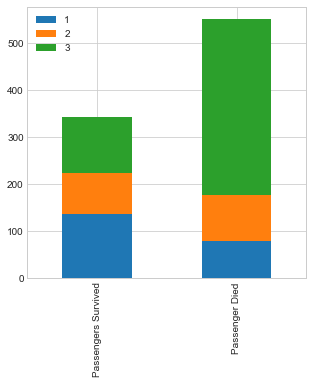

In [25]:
# plot survival rate bar chart per Pclass
bar_chart_stacked(training_data, 'Pclass')

Based on the plots above, we can make the following observations : 
- Even if most of passengers had class 3 tickets, only 24% of them survived
- On the other hand, 63% of passengers from class 1 survived and about 48% of class 2 did. This clearly indicated a relationship between the passenger class and probability of survival.

However, we need to verify if the passenger class is the driver behind this trend. Indeed, the percentages we observe can be related to the fact that most of the passengers from class 1 and 2 are females while class 3 is mainly composed of men.

### Question #3.1 : Is the higher survival rate in Class 1 due to the class itself or to a gender distribution in which female passengers dominate?

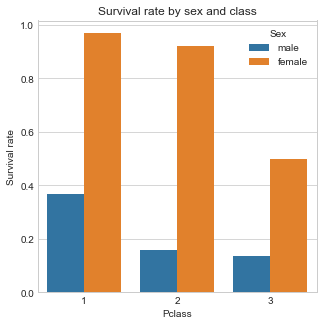

In [26]:
bar_chart_compare(training_data, "Survival rate by sex and class", "Pclass", "Sex", "Survived", "Survival rate")

In [27]:
training_data.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

Here we can observe that irrespective of the class the most important factor when it comes to surviving was gender.

However, there is also a clear trend showing that the lower the class of passenger, the lower the chances of survival. For example, a men from class 1 has nearly 3 times more chances to survive compared to a men from class 3.

Thus, we should keep both features as both yield insightful information that should help our model.

## Question #4 : Does the age of the passenger influence the chance of survival ?

Feature : Age

Description: Age of the passengers.

We need to be cautious at the moment with this column as 20% of missing values. To start with, let's ignore that aspect and explore the relationship between age and survival. If there is a pattern, then we will fill the missing values with a robust method. 

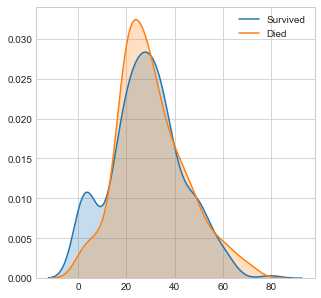

In [28]:
plot_kernel_density_estimate_survivors(training_data, "Age", "Age distribution Survived vs Died")

The kernel density estimate does not provide additional information except from a raise in survivors at a very young age. 

However, we might investigate age and sex together using a swarm plot, as it does not seem plausible that age has no influence on the chance of survival considering children and females were evacuated in priority according to the chain of events.

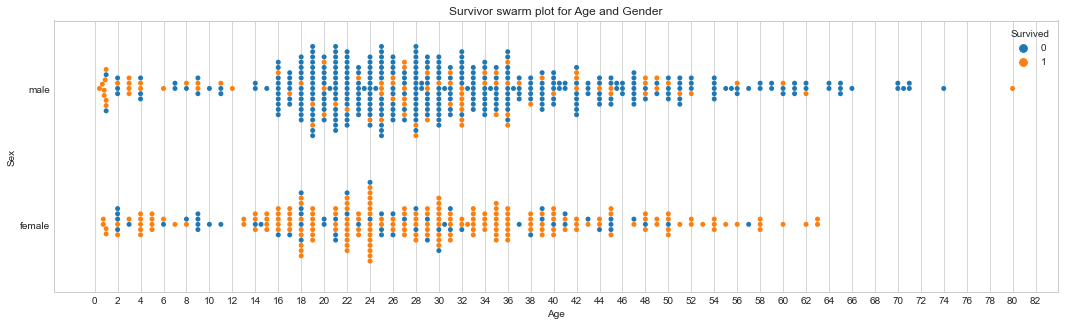

In [29]:
plot_swarm(training_data, "Survived", "Sex", "Age", "Survivor swarm plot for Age and Gender")

Among males, we can see that the survivors are concentrated in the the area between 0 and 12 years old, which confirms that age holds valuable information.

If we look at the swarm plot for Age and Pclass, it makes even clearer that Pclass is a decisive criteria in terms of likelihood to survive. We can also notice from this chart that there was a very low amount of children in the first class compared to 2nd and 3rd.

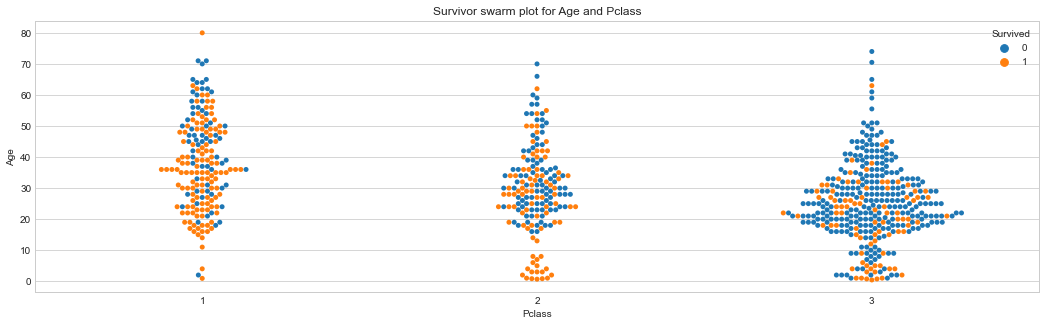

In [30]:
plot_swarm(training_data, "Survived", "Age", "Pclass", "Survivor swarm plot for Age and Pclass")

## Question #5 : Does the ticket price influence the chance of survival ?

Feature : Fare

Description: the fare paid by the passenger.

To better understand how this feature influences the survival rate, we could plot bar plots of Fare vs Survived.

However, due to the large range of fares such as plot would not be useful for inferring useful information.
A more suited visualization would be to combine fares into categories and then plot the categories vs Survived.

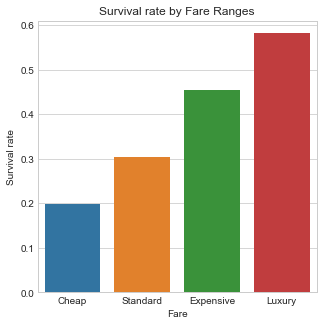

In [31]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']
plot_quartiles(training_data, 
               "Fare", 
               "Survived", 
               chart_title="Survival rate by Fare Ranges", 
               categories=categories, 
               y_axis_label="Survival rate")

As we can see the likelihood of survival is definitely influenced by the price paid : 
- Cheap (0–25% of max Price): Surival Rate = 0.2 (aprox)
- Standard (25%-50% of max Price): Surival Rate = 0.3 (aprox)
- Expensive (50%-75% of max Price): Surival Rate = 0.45 (aprox)
- Luxury (75%-100% of max Price): Surival Rate = 0.55 (aprox)

In [32]:
# Creation of 4 categories
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']
training_data['Fare_cat'] = pd.qcut(training_data['Fare'], len(categories), labels = categories)
test_data['Fare_cat'] = pd.qcut(test_data['Fare'], len(categories), labels = categories)

## Question #6 : Does the place of embarkation influence chance of survival ?

Description: the port in which the passenger embarked.

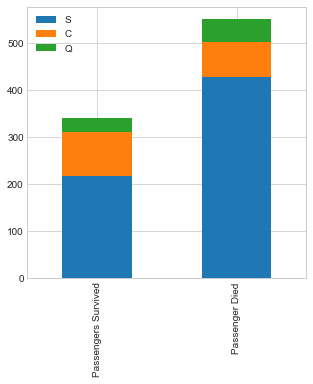

In [33]:
# plot survival rate bar chart per place of Embarkation
bar_chart_stacked(training_data, 'Embarked')

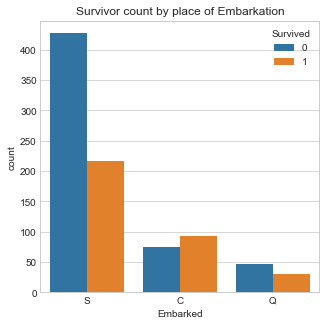

In [34]:
# plot count or passengers who Survived and Died per place of Embarkation
countplot_compare(training_data, "Embarked", "Survived", "Survivor count by place of Embarkation")

In [35]:
pd.pivot_table(training_data, index = 'Survived', columns = 'Embarked', values = 'Ticket', aggfunc='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


From this perspective, we can see that passengers who Embarked in Cherbourg were more likely to survive compare to others. On the other hand, passengers from Southampton has significantly lower chances to survive.

Based on the context of events and knowing the importance of Pclass feature, it is likely that this is due to the percentage of Class 1 passengers which might be higher in Cherbourg compared to other ports.

### Question 6.1 : Is the high number of survivors that embarked at Cherbourg due to a high number of 1. Class passengers?

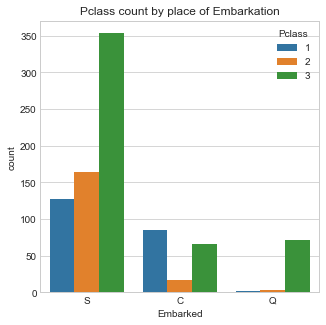

In [36]:
countplot_compare(training_data, "Embarked", "Pclass", "Pclass count by place of Embarkation")

This chart confirms our intuition : 
- The majority embarked at Cherbourg were 1. class passengers.
- The majority embarked at Southampton were 3. class passengers.

However, it does not explain why the survival rate for Queenstown passengers is slightly higher than at Southampton even though the number of 1. class passenger in relation to 3. class passengers is higher at Southampton.

One hypothesis is that maybe the ratio between male and female passengers differs.

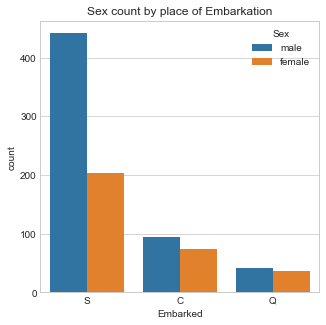

In [37]:
countplot_compare(training_data, "Embarked", "Sex", "Sex count by place of Embarkation")

As expected twice as much male passengers embarked from Southamp were roughly the same number of male and female passengers embarked from Queenstown. This just shows the importance of the Sex feature.

## Question #7 : Does the number of children/siblings/spouses or parents on board influence the chance of survival ?

Feature : SibSp 

Description: The number of siblings/spouses the passenger has aboard the Titanic

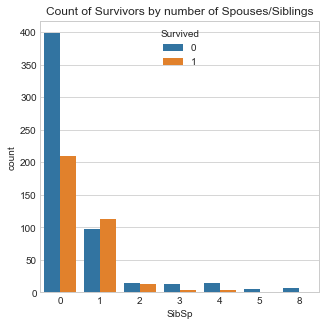

In [38]:
countplot_compare(training_data, "SibSp", "Survived", "Count of Survivors by number of Spouses/Siblings")

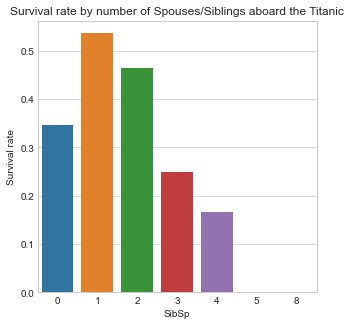

In [39]:
bar_chart_compare(training_data, 
                  chart_title="Survival rate by number of Spouses/Siblings aboard the Titanic", 
                  feature1="SibSp", 
                  feature2=None, 
                  target="Survived", 
                  y_axis_label="Survival rate")

As we can see from the plots above, the majority of passengers traveled alone. It seems that the more siblings a passenger has the less chance of survival there is.

Feature : Parch 

Description: The number of children/parents the passenger has aboard the Titanic

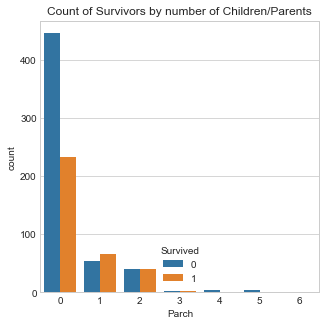

In [40]:
countplot_compare(training_data, "Parch", "Survived", "Count of Survivors by number of Children/Parents")

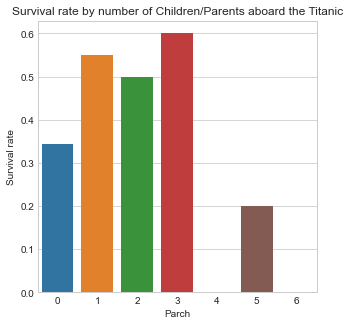

In [41]:
bar_chart_compare(training_data, 
                  chart_title="Survival rate by number of Children/Parents aboard the Titanic", 
                  feature1="Parch", 
                  feature2=None, 
                  target="Survived", 
                  y_axis_label="Survival rate")

We can see that small families had more chances to survive than bigger ones and passengers who traveled alone.

It's interesting to see that the passengers with one or two spouses or siblings had more survivors than deaths.

# 3. Feature Engineering

## Feature: Title

In [42]:
pd.unique(training_data['Name'])

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

Here we can observe that every passenger has a unique name which makes it difficult to identify some categories of users. 

However, there we can notice that there are some repetitive titles in the names' structure such as 'Mrs', 'Mr', 'Miss', etc. Let's transform the column to extract this pattern and explore the values.

In [43]:
# Extract title from passenger's name
train_titles = [x.split(',')[1].split('.')[0] for x in training_data.Name]
test_titles = [x.split(',')[1].split('.')[0] for x in test_data.Name]

In [44]:
# Add title to dataframes
training_data['Title'] = train_titles
test_data['Title'] = test_titles

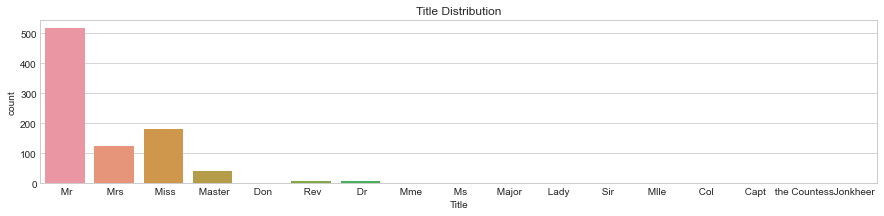

In [45]:
countplot(training_data, "Title", "Title Distribution", (15, 3))

To make the following charts more readable, we will group the less frequent titles together.

In [46]:
# Group less frequent values under Mr or Mrs
training_data['Title'] = training_data['Title'].replace(['Don','Mme', "Ms", "Major", "Lady", "Sir", "Mlle", "Capt", "The Countess", "Jonkheer", "Col", "the Countess"],
                                                        ['Mr','Mrs', "Mrs", "Mr", "Mrs", "Mr", "Mrs", "Mr", "Mrs", "Mr", "Mr", "Mrs"], 
                                                        regex=True)

test_data['Title'] = test_data['Title'].replace(['Don','Mme', "Ms", "Major", "Lady", "Sir", "Mlle", "Capt", "The Countess", "Jonkheer", "Col", "the Countess"],
                                                        ['Mr','Mrs', "Mrs", "Mr", "Mrs", "Mr", "Mrs", "Mr", "Mrs", "Mr", "Mr", "Mrs"], 
                                                        regex=True)

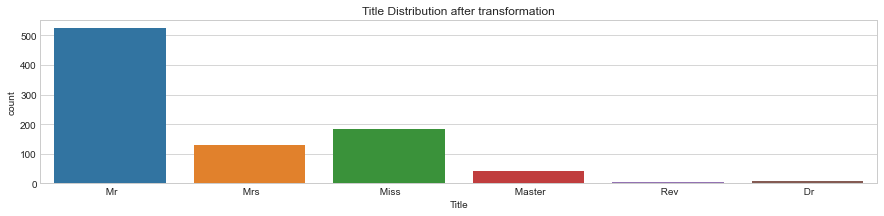

In [47]:
countplot(training_data, "Title", "Title Distribution after transformation", (15, 3))

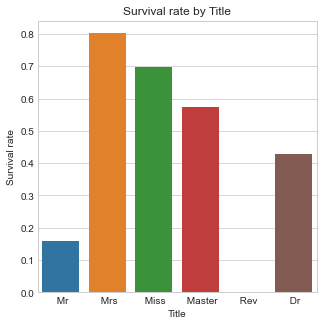

In [48]:
bar_chart_compare(training_data, 
                  chart_title="Survival rate by Title", 
                  feature1="Title", 
                  feature2=None, 
                  target="Survived", 
                  y_axis_label="Survival rate")

As Expected female Titles result in a higher survival rate. Master and Dr slightly have a surprisingly high survival rate even tough both are male titles. Being “just” a Mr comes with a compromised survival rate of approx 15%. 

## Feature: Family size

SibSp and Parch columns provide us some information about the family members of the passengers that are onboard the Titanic. We can easily compute the family size by combining both features.

In [49]:
training_data['Fam_size'] = training_data['SibSp'] + training_data['Parch'] + 1
test_data['Fam_size'] = test_data['SibSp'] + test_data['Parch'] + 1

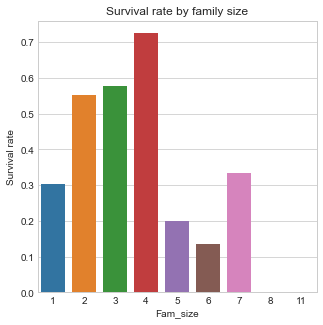

In [50]:
bar_chart_compare(training_data, 
                  chart_title="Survival rate by family size", 
                  feature1="Fam_size", 
                  feature2=None, 
                  target="Survived", 
                  y_axis_label="Survival rate")

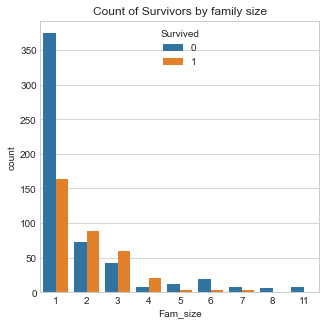

In [51]:
countplot_compare(training_data, "Fam_size", "Survived", "Count of Survivors by family size")

To make it more readable, we can group the family size into categories.

In [52]:
# Creation of 4 groups
training_data['Fam_type'] = pd.cut(training_data.Fam_size, [0, 1, 4, 7, 11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_data['Fam_type'] = pd.cut(test_data.Fam_size, [0, 1, 4, 7, 11], labels=['Solo', 'Small', 'Big', 'Very big'])

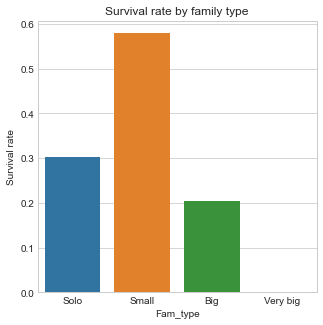

In [53]:
bar_chart_compare(training_data, 
                  chart_title="Survival rate by family type", 
                  feature1="Fam_type", 
                  feature2=None, 
                  target="Survived", 
                  y_axis_label="Survival rate")

# 4. Data preprocessing

Now, we need to make our data ready to execute the models.

## Drop null values

As there are only 2 missing values in the Embarked column, we will just delete them.

In [54]:
training_data = training_data.dropna(subset=['Embarked'])

Then, the column with the most missing values in Cabin. Since 70%+ values are missing, it does not make sense for us to fill in missing values.. There would just be too much noise in the ML model and we may actually get a lower score because of this. We will just drop it from our dataset.

In [55]:
training_data = training_data.drop('Cabin', axis=1)

## Impute missing values

However, we need to find a way to deal with the 20% of missing values in the Age column. We can't delete the rows impacted as we would lose too much information.

Based on the Exploratory Data Analysis section, we know that children have a better chance of survival compared to adults. Here, we don't care about getting the exact age of the passenger but rather to predict well his/her age category.

We could simply impute the missing values by the mean of the column but that would be too imprecise. We would rather look for the mean ages among passengers that have similar characteristics such as : PClass and Title.

In [56]:
training_data.groupby(['Title', 'Pclass'])['Age'].agg(['mean', 'count'])

mean  count
Title   Pclass                  
 Dr     1       43.750000      4
        2       38.500000      2
 Master 1        5.306667      3
        2        2.258889      9
        3        5.350833     24
 Miss   1       29.818182     44
        2       22.390625     32
        3       16.123188     69
 Mr     1       42.394737     95
        2       32.768293     82
        3       28.724891    229
 Mrs    1       38.973684     38
        2       33.547619     42
        3       33.515152     33
 Rev    2       43.166667      6

The differences in the average ages among the same groups is striking. For example, if we look closer at the Miss group, the average is 29 is Class 1 versus respectively 22 and 16 is Class 2 and 3. With such differences, we can definitely wonder if the segmentation we have chosen is precise enough to differentate children from adults females.

As we can see in our table, identrifying male children is easy as they have the "Master" Title. For females, we don't have that. However, we can leverage the Parch column which should indicate whether the passenger is travelling with her parents or not.

In [57]:
print("Avg age of 'Miss' Title", round(training_data[training_data.Title==" Miss"]['Age'].mean()))
print("Avg age of 'Miss' Title travelling without Parents", round(training_data[(training_data.Title==" Miss") & (training_data.Parch==0)]['Age'].mean()))
print("Avg age of 'Miss' Title travelling with Parents", round(training_data[(training_data.Title==" Miss") & (training_data.Parch!=0)]['Age'].mean()), '\n')

Avg age of 'Miss' Title 22
Avg age of 'Miss' Title travelling without Parents 28
Avg age of 'Miss' Title travelling with Parents 12 



As expected, there are huge differences based on the Parch field. Let's use it to make our final segmentation of passengers and impute the missing age values.

In [58]:
training_data['Age'].fillna(training_data.groupby(['Pclass','Sex','Title'])['Age'].transform('mean'), inplace=True)

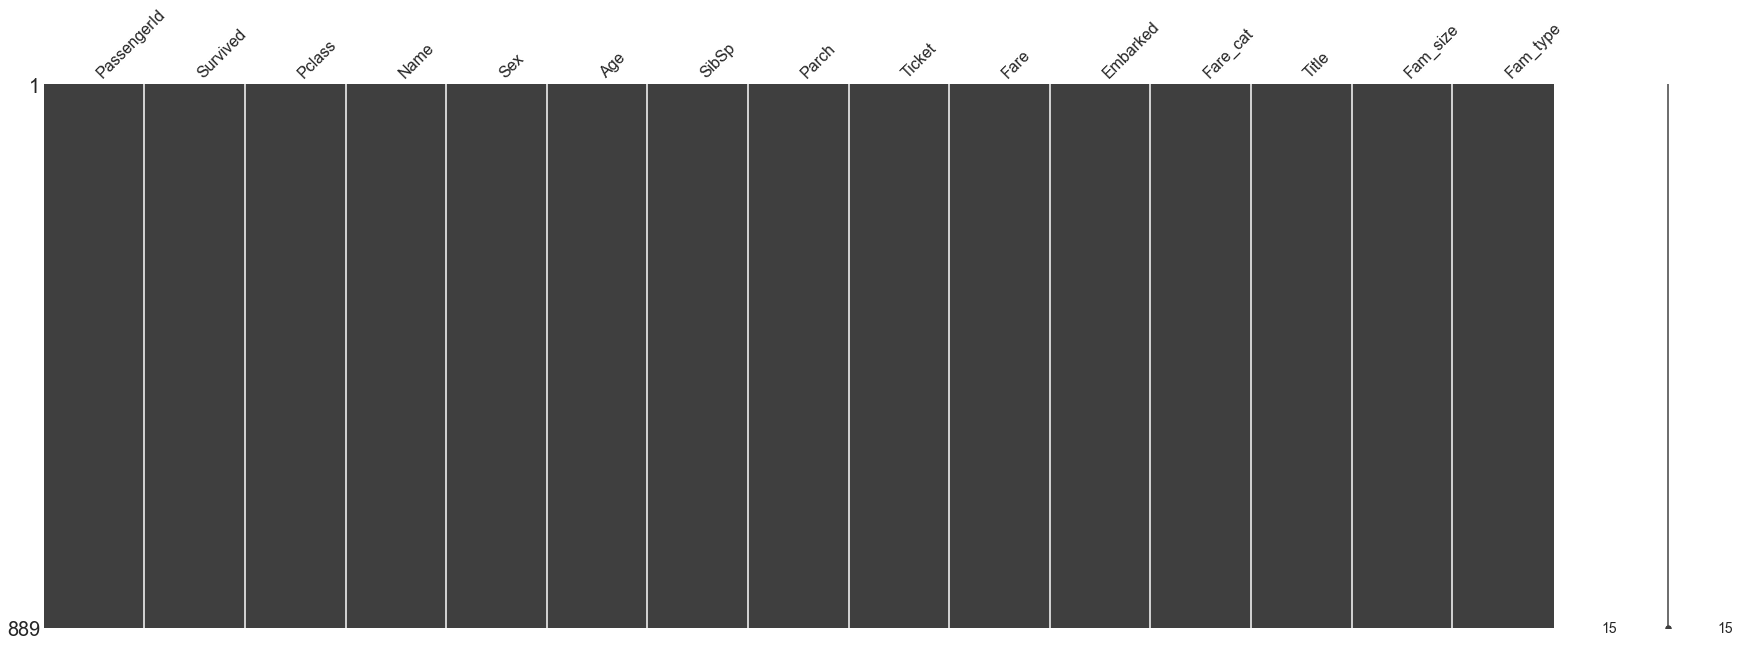

In [59]:
missingno.matrix(training_data, figsize = (30,10))

We have now fixed all the missing data issues, we can move on to the next step which is feature selection!

## Select only valuable features

Since we have limited data, we want to exclude things like name and passenger ID so that we could have a reasonable number of features for our models to deal with. 

I also decided to delete Ticket as I was not able to detect any pattern in the EDA phase. 

Lastly, I dropped the Fare column as we have created Fare_cat which simplifies a lot the work for the algorithm as it is binned into categories.

In [60]:
training_data = training_data.drop(['PassengerId', 'Name', 'Ticket', 'Fare'], axis=1)

In [61]:
training_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare_cat,Title,Fam_size,Fam_type
0,0,3,male,22.0,1,0,S,Cheap,Mr,2,Small
1,1,1,female,38.0,1,0,C,Luxury,Mrs,2,Small
2,1,3,female,26.0,0,0,S,Standard,Miss,1,Solo
3,1,1,female,35.0,1,0,S,Luxury,Mrs,2,Small
4,0,3,male,35.0,0,0,S,Standard,Mr,1,Solo


## Encode the data

Now we have our dataframe ready. We can encode the features so they're ready to be used with our machine learning models.

In [62]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(training_data['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(training_data['Sex'], 
                                prefix='sex')

df_pclass_one_hot = pd.get_dummies(training_data['Pclass'], 
                                   prefix='pclass')

df_farecat_one_hot = pd.get_dummies(training_data['Fare_cat'], 
                                   prefix='fare_cat')

df_title_one_hot = pd.get_dummies(training_data['Title'], 
                                   prefix='title')

df_famtype_one_hot = pd.get_dummies(training_data['Fam_type'], 
                                   prefix='fam_type')

In [63]:
# Combine the one hot encoded columns with training_data
training_data_enc = pd.concat([training_data, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_pclass_one_hot,
                        df_farecat_one_hot, 
                        df_title_one_hot, 
                        df_famtype_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
training_data_enc = training_data_enc.drop(['Pclass', 'Sex', 'Embarked', 'Fare_cat', 'Title', 'Fam_type'], axis=1)

In [64]:
training_data_enc.head()

,Survived,Age,SibSp,Parch,Fam_size,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,...,title_ Dr,title_ Master,title_ Miss,title_ Mr,title_ Mrs,title_ Rev,fam_type_Solo,fam_type_Small,fam_type_Big,fam_type_Very big
0,0,22.0,1,0,2,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0
1,1,38.0,1,0,2,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,1,26.0,0,0,1,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
3,1,35.0,1,0,2,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
4,0,35.0,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0


# 5. Machine Learning Model Building

Now that we have finalised the preprocessing step, we can run models on it to predict which passengers survived.

In [65]:
selected_df = training_data_enc

## Data separation

In [66]:
X_train = selected_df.drop("Survived", axis = 1) #data
y_train = selected_df.Survived #label

## Machine Learning algorithms selection

In the context of this project, we are facing a classification problem. 

We will apply the following algorithms to our training data and see which one yields the best results : 
- Logistic Regression
- Support Vector Machine
- Decision Tree Classifier
- K-Nearest-Neighbours
- Random Forest Classifier

As we will be using sklearn library only, we will write a function to standardise the execution of models and printing accuracy scores. The function will first estimate the parameters for the Machine Learning algorithm (training), then it will evaluate how well the method worked (testing).

## Run models

In [67]:
def fit_ml_algo(algo, X_train, y_train, cv):
    """
    Function that runs the requested algorithm and returns the accuracy metrics.
        Parameters
            algo: the name of the algorithm we will run from sklearn library
            X_train: the input data of the model
            y_train: the real values of the target feature from training dataset
            cv: k-fold cross validation, the number of blocks in which we divide our data
            n_jobs: number of CPU cores used during cross validation loop (-1 means using all processors)
        Return
            acc: model accuracy score
            acc_cv: the adjusted accuracy score after k-fold cross validation
    
    """
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [68]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 82.9
Accuracy CV 10-Fold: 82.9
Running Time: 0:00:03.625140


### Support Vector Machine

In [69]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 83.01
Accuracy CV 10-Fold: 76.83
Running Time: 0:00:00.212542


### K-Nearest-Neighbours

In [70]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 85.26
Accuracy CV 10-Fold: 80.31
Running Time: 0:00:00.111385


### Decision Tree Classifier

In [71]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 95.28
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.077565


### Random Forest Classifier

In [72]:
# Random Forest Classifier
start_time = time.time()
train_pred_rf, acc_rf, acc_cv_rf = fit_ml_algo(RandomForestClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 94.15
Accuracy CV 10-Fold: 78.97
Running Time: 0:00:00.130827


## Model results

### Accuracy scores

Here we will be looking at the cross-validation accuracy score to pick the most performant model, as the standard .fit() method can randomly score higher than usual.

In [73]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',
              'Linear SVC', 'Decision Tree', 'Random Forest'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_rf
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
1,Logistic Regression,82.90
0,KNN,80.31
4,Random Forest,78.97
3,Decision Tree,77.95
2,Linear SVC,76.83


Because the Logistic Regression algorithm provides the best results, we will use it for the next steps.

### Feature importance

Which features of the best model were most important for making predictions?

In [74]:
# Store the best performing model in a variable
model_lr = LogisticRegression().fit(X_train, y_train)

# Build a dataframe with the predictive power of each feature
feature_names = list(X_train.columns)
feature_importance = pd.DataFrame(feature_names, columns=["Feature"])
feature_importance['Importance'] = pow(math.e, model_lr.coef_[0])
feature_importance = feature_importance.sort_values(by = ['Importance'], ascending=False)

feature_importance

,Feature,Importance
17,title_ Master,5.911101
9,pclass_1,2.933775
7,sex_female,2.727943
22,fam_type_Solo,2.471845
23,fam_type_Small,2.289498
20,title_ Mrs,2.119921
15,fare_cat_Luxury,1.614290
4,embarked_C,1.269725
14,fare_cat_Expensive,1.209629
5,embarked_Q,1.207201


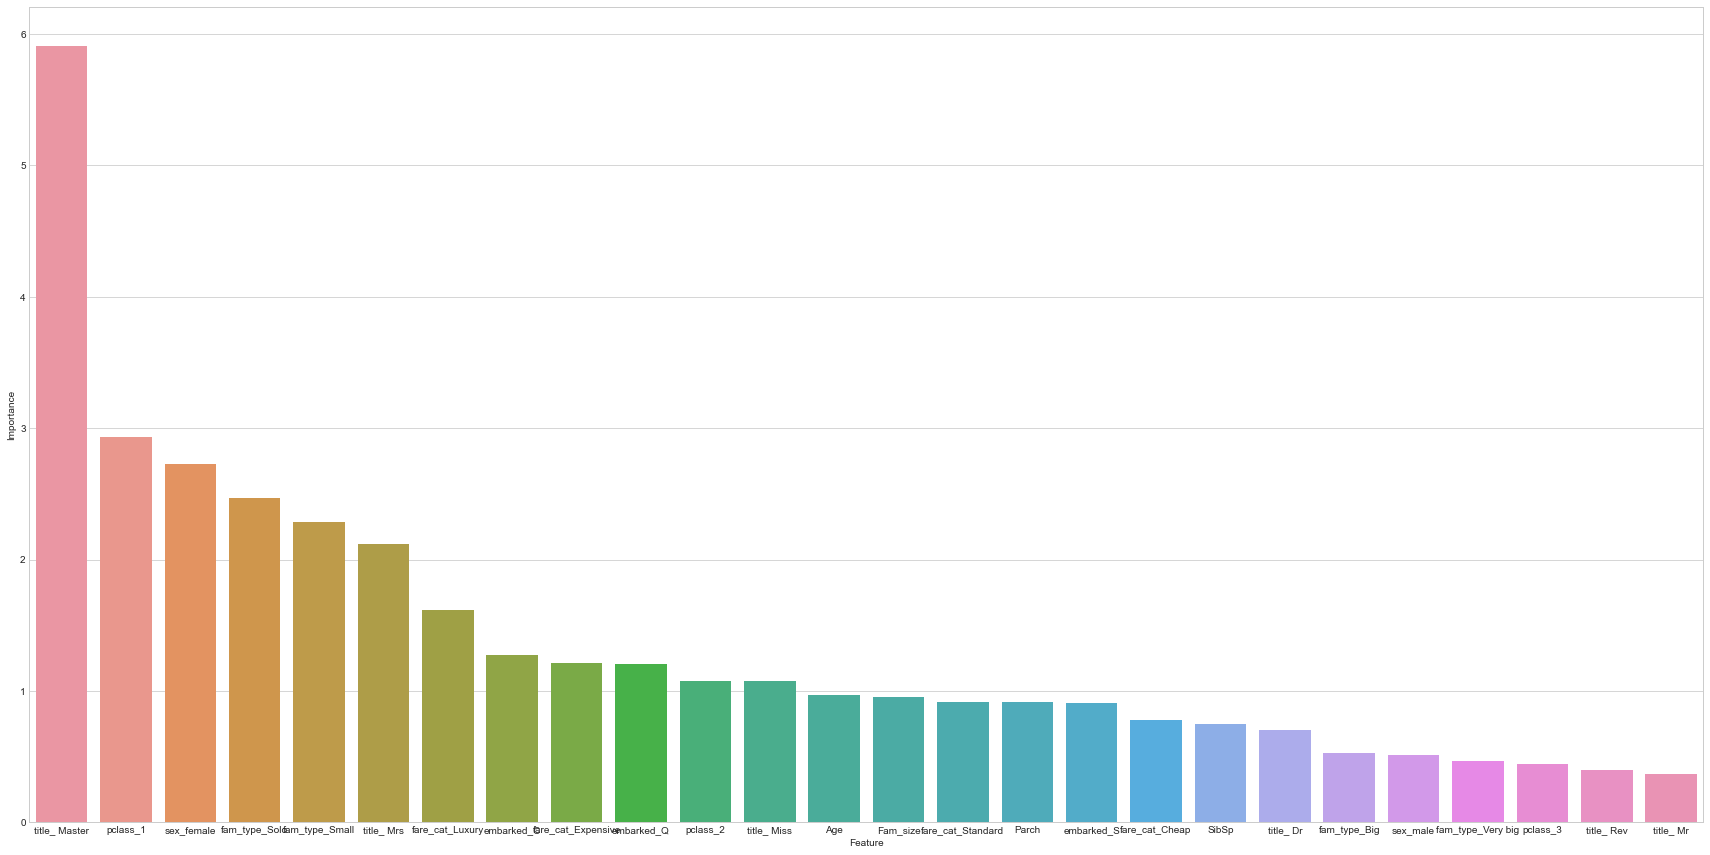

In [75]:
# Plot the feature importance
plt.figure(figsize = [30, 15])
sns.barplot(x='Feature', y='Importance', data=feature_importance)

To sum up, the strongest feature (by far) to predict Survival in Titanic Dataset based on Logistic Regression is the title Master. Being a young male child increases the odds of Surviving by a factor of 5.91 when all other features remain the same.

## Submission

We will use the model with the highest cross validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model.

In [76]:
# The test dataframe should have the same structure as the one below
X_train.head()

,Age,SibSp,Parch,Fam_size,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,...,title_ Dr,title_ Master,title_ Miss,title_ Mr,title_ Mrs,title_ Rev,fam_type_Solo,fam_type_Small,fam_type_Big,fam_type_Very big
0,22.0,1,0,2,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,38.0,1,0,2,1,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
2,26.0,0,0,1,0,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,0
3,35.0,1,0,2,0,0,1,1,0,1,...,0,0,0,0,1,0,0,1,0,0
4,35.0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0


In [77]:
# Here is how our test dataframe looks like
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Title,Fam_size,Fam_type
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Cheap,Mr,1,Solo
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Cheap,Mrs,2,Small
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Standard,Mr,1,Solo
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Standard,Mr,1,Solo
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Standard,Mrs,3,Small


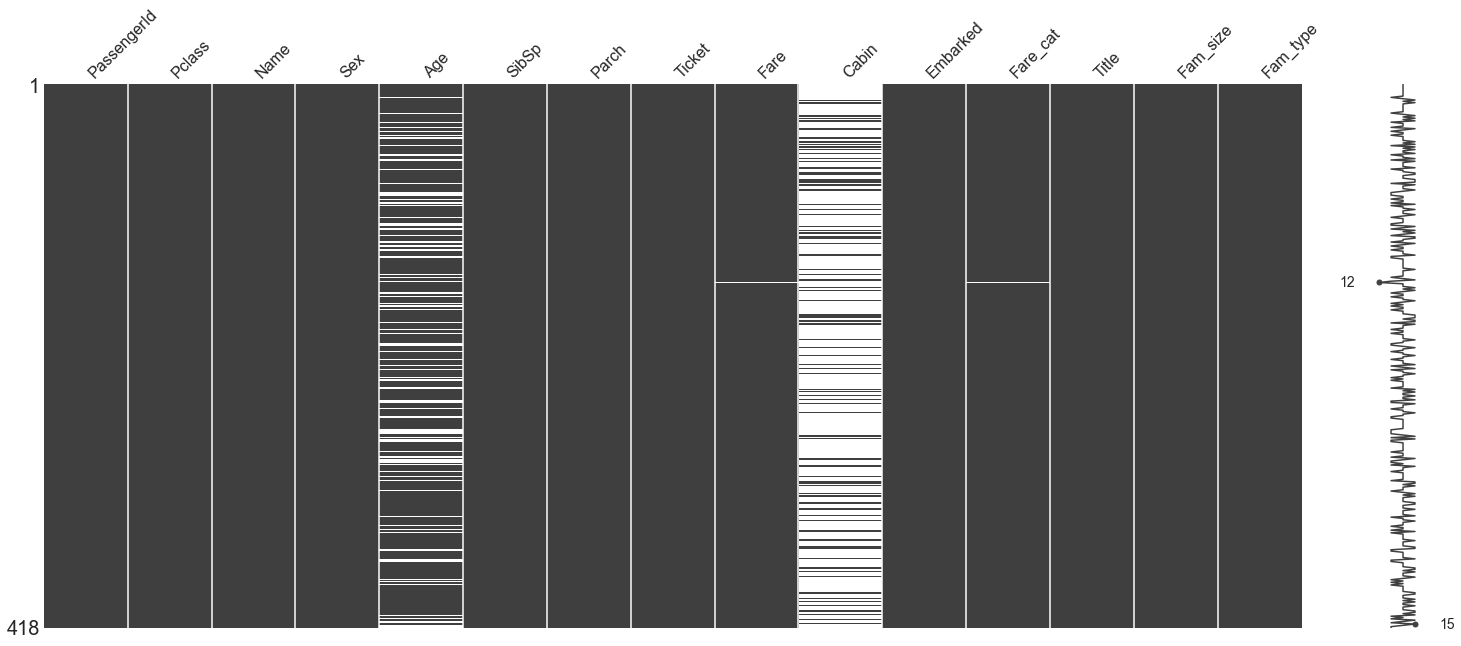

In [78]:
missingno.matrix(test_data)

In [79]:
# Delete the row with the missing Fare value
test_data['Fare'].fillna(test_data['Fare'].mean(), inplace=True)

# Delete the Cabin column since there are too much missing values
test_data = test_data.drop('Cabin', axis=1)

# Impute the missing value in Age with the same methodology as we have done with training data
test_data['Age'].fillna(test_data.groupby(['Pclass','Sex','Title'])['Age'].transform('mean'), inplace=True)

In [80]:
missing_vals = pd.DataFrame.from_dict(count_missing_values(test_data), orient='index').rename(columns={0: "Count of missing values (%)"})
missing_vals

Number of missing or NaN value for each column:


,Count of missing values (%)
PassengerId,0 (0.0%)
Pclass,0 (0.0%)
Name,0 (0.0%)
Sex,0 (0.0%)
Age,0 (0.0%)
SibSp,0 (0.0%)
Parch,0 (0.0%)
Ticket,0 (0.0%)
Fare,0 (0.0%)
Embarked,0 (0.0%)


In [81]:
# One hot encode the columns like we did in the X_train dataframe
test_embarked_one_hot = pd.get_dummies(test_data['Embarked'], 
                                     prefix='embarked')

test_sex_one_hot = pd.get_dummies(test_data['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test_data['Pclass'], 
                                   prefix='pclass')

test_farecat_one_hot = pd.get_dummies(test_data['Fare_cat'], 
                                   prefix='fare_cat')

test_title_one_hot = pd.get_dummies(test_data['Title'], 
                                   prefix='title')

test_famtype_one_hot = pd.get_dummies(test_data['Fam_type'], 
                                   prefix='fam_type')

In [82]:
# Combine test dataframe with one hot encoded columns
test_enc = pd.concat([test_data, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot,
                  test_farecat_one_hot,
                  test_title_one_hot,
                  test_famtype_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
test_enc = test_enc.drop(['Pclass', 'Sex', 'Embarked', 'Fare_cat', 'Title', 'Fam_type'], axis=1)

In [83]:
# Select the list of columns to be used for the predictions
test_enc = test_enc.drop(['PassengerId', 'Name', 'Ticket', 'Fare'], axis=1)

In [84]:
test_enc.columns

Index(['Age', 'SibSp', 'Parch', 'Fam_size', 'embarked_C', 'embarked_Q',
       'embarked_S', 'sex_female', 'sex_male', 'pclass_1', 'pclass_2',
       'pclass_3', 'fare_cat_Cheap', 'fare_cat_Standard', 'fare_cat_Expensive',
       'fare_cat_Luxury', 'title_ Dr', 'title_ Master', 'title_ Miss',
       'title_ Mr', 'title_ Mra', 'title_ Mrs', 'title_ Rev', 'fam_type_Solo',
       'fam_type_Small', 'fam_type_Big', 'fam_type_Very big'],
      dtype='object')

In [86]:
test_enc = test_enc.drop('title_ Mra', axis=1)

In [87]:
# Run our model on test data (unseen data on which the model hasn't been trained on)
predictions = model_lr.predict(test_enc[test_enc.columns])

In [88]:
# first 10 outcomes predicted by our model
predictions[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [89]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [90]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test_data):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [91]:
# Convert submisison dataframe to csv for submission to csv for Kaggle submisison
submission.to_csv('logistic_regression_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!
